In [11]:
from PIL import Image
import os
len(sorted(os.listdir('./VOC2007_augmentation_pottedplant/JPEGImages')))

891

### Augmentation testing

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import os
import cv2
import copy
import random
from tqdm import tqdm
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from dataset_utils import parse_annotation, modify_annotation
from BaselineAugmenterPipeline import augmenter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
object_classes = ["bicycle", "aeroplane", "bird", "boat", "bottle",
                "bus", "car", "cat", "chair", "cow",
                "dining table", "dog", "horse", "motorbike", "person",
                "potted plant", "sheep", "sofa", "train", "tvmonitor"]

In [5]:
dataset_path = './VOC2007'
annotation_path = os.path.join(dataset_path,'Annotations/000007.xml')
image_filename, annotations = parse_annotation(annotation_path)
image_filename = image_filename.rsplit('.', 1)[0]

In [6]:
annotations

{'car': [(<PIL.Image.Image image mode=L size=500x333>, 0)]}

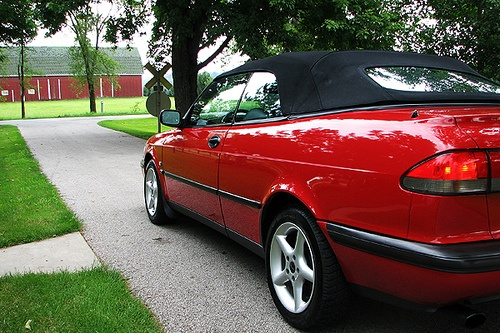

In [7]:
current_object = 'car'
mask, ind = annotations[current_object][0]
image = Image.open(os.path.join('./VOC2007/JPEGImages', image_filename+'.jpg'))
image

In [26]:
model = augmenter()

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.94s/it]
/home/jovyan/.mlspace/envs/ddorin_augmenter/lib/python3.8/site-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An 

07/04 18:11:53 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
07/04 18:11:53 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


100%|██████████| 50/50 [00:01<00:00, 36.79it/s]


New object: dog, prompt: The small brown mixed-breed dog confidently stands with its tail wagging, showing eagerness and alertness in every gesture.



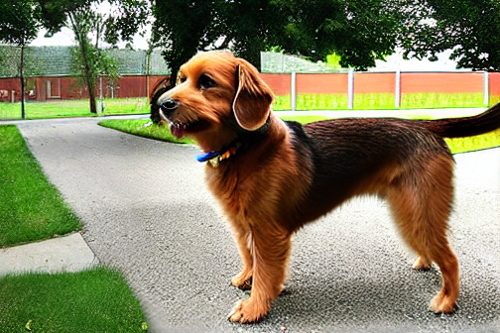

In [28]:
set_seed(2)
new_image, new_object, prompt = model(pil_image=image,
                                    pil_mask=mask,
                                    current_object=current_object,
                                    new_objects_list=['dog'],
                                    num_inference_steps=50,
                                    guidance_scale=7.5,
                                    strength=1.0,
                                    return_prompt=True)

print(f'New object: {new_object}, prompt: {prompt}\n')
new_image.show()

In [8]:
from blending_PowerPaintPipeline import infer, poisson_blend
from PowerPaintPipeline import StableDiffusionInpaintPipeline as Pipeline
from PowerPaintPipeline import TokenizerWrapper, add_tokens
from safetensors.torch import load_model

In [9]:
weight_dtype = torch.float16
pipe = Pipeline.from_pretrained("runwayml/stable-diffusion-inpainting", 
                                                            torch_dtype=weight_dtype,
                                                            safety_checker=None,
                                                            requires_safety_checker=False)
pipe.tokenizer = TokenizerWrapper(
                                from_pretrained="runwayml/stable-diffusion-v1-5", subfolder="tokenizer", revision=None)

add_tokens(
            tokenizer=pipe.tokenizer,
            text_encoder=pipe.text_encoder,
            placeholder_tokens=["P_ctxt", "P_shape", "P_obj"],
            initialize_tokens=["a", "a", "a"],
            num_vectors_per_token=10)

load_model(pipe.unet, "./unet/unet.safetensors")
load_model(pipe.text_encoder, "./unet/text_encoder.safetensors", strict=False)
pipe = pipe.to("cuda")

text_encoder/model.safetensors not found
Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:00,  6.01it/s]An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  33%|███▎      | 2/6 [00:06<00:15,  3.90s/it]An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion

07/04 21:06:15 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
07/04 21:06:15 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


In [10]:
prompt = "The small brown mixed-breed dog confidently stands with its tail wagging, showing eagerness and alertness in every gesture."

negative_prompt = "text, bad anatomy, bad proportions, blurry, cropped, deformed, disfigured, "\
                    "duplicate, error, extra limbs, gross proportions, jpeg artifacts, long neck, "\
                    "low quality, low res, malformed, morbid, mutated, mutilated, out of frame, ugly, worst quality"

task = "text-guided"

In [11]:
input_image = {'image': image, 'mask': mask}

In [12]:
dict_out, dict_res = infer(
    pipe=pipe,
    input_image=input_image,
    text_guided_prompt=prompt,
    text_guided_negative_prompt=negative_prompt,
    shape_guided_prompt=None,
    shape_guided_negative_prompt=None,
    fitting_degree=1,
    ddim_steps=50,
    scale=12,
    seed=4,
    task=task,
    enable_control=True,
    input_control_image=None,
    control_type="depth",
    vertical_expansion_ratio=1,
    horizontal_expansion_ratio=1,
    outpaint_prompt=None,
    outpaint_negative_prompt=None,
    controlnet_conditioning_scale=None,
    removal_prompt=None,
    removal_negative_prompt=None,
)

100%|██████████| 50/50 [00:02<00:00, 17.03it/s]


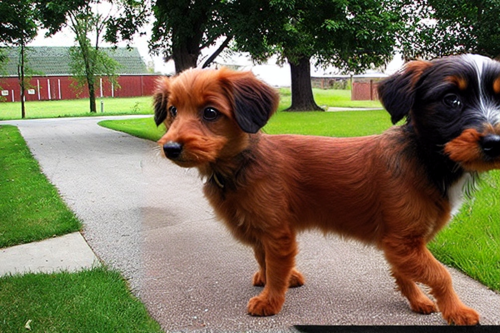

In [18]:
fake = dict_out[1].resize(image.size)
fake

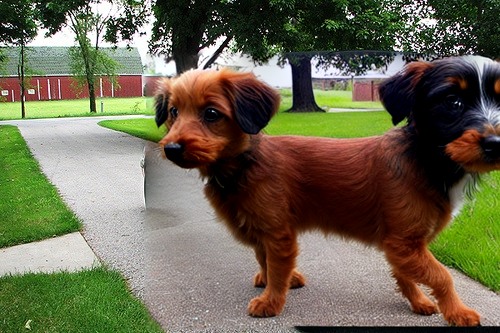

In [14]:
# Метод Никиты
output = poisson_blend(image, dict_out[1].resize(image.size), np.array(mask))
Image.fromarray(np.uint8(output))

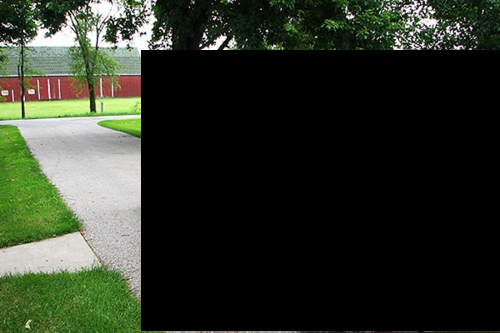

In [53]:
mask_arr = np.array(mask)
mask_arr = 1 - mask_arr / 255.0
image_arr = np.array(dict_out[1].resize(image.size))

# Применяем маску к изображению
result = image_arr * mask_arr[:, :, np.newaxis]

Image.fromarray(np.uint8(result))

### Рассмотрим следующий вариант [**Blending**](https://github.com/bcmi/libcom/tree/main).

In [ ]:
from libcom import color_transfer

In [19]:
a = color_transfer(np.array(fake), np.array(mask))

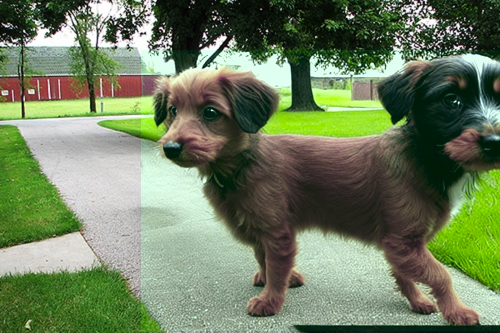

In [20]:
Image.fromarray(np.uint8(a))

In [ ]:
CDTNet = libcom.ImageHarmonizationModel(device=0, model_type='CDTNet')